### Exploratory Data Analysis

Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as pe
import wordcloud
import nltk
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the dataset
df = pd.read_csv("../dataset/spam.csv", encoding='latin-1')

In [7]:
#Basic EDA on the dataset

df.head() # dataset contains 5 columns of which 2 are unnamed which can be dropped & other renamed for readability
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.rename(columns = {'v1':'class_label','v2':'message'},inplace=True)
df.head()

,class_label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [8]:
# Lets look at the distribution of labels in the dataset

fig = pe.histogram(df, x="class_label", color="class_label", color_discrete_sequence=["#871fff","#ffa78c"])
fig.show()
# Very imbalanced dataset 747 spam & 4825 are nonSpam

fig = pe.pie(df.class_label.value_counts(),labels='index', values='class_label', color="class_label", color_discrete_sequence=["#871fff","#ffa78c"] )
fig.show()

In [11]:
# Feature Engineering

#Lets look at the length of the messages to get some insights btw spam & nonSpam
df['length'] = df['message'].apply(len)
df.head()

fig = pe.histogram(df, x="length", color="class_label", color_discrete_sequence=["#871fff","#ffa78c"] )
fig.show()

Having a view of the most common words used in spams and hams will help us understand the dataset better. A word cloud can give you an idea of what kind of words are dominant in each class. To make a word cloud, first separate the classes into two pandas data frames and add a simple word cloud function

In [12]:
data_ham  = df[df['class_label'] == "ham"].copy()
data_spam = df[df['class_label'] == "spam"].copy()

def show_wordcloud(df, title):
    text = ' '.join(df['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords, background_color="#ffa78c",
                                        width = 3000, height = 2000).generate(text)
    plt.figure(figsize=(15,15), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

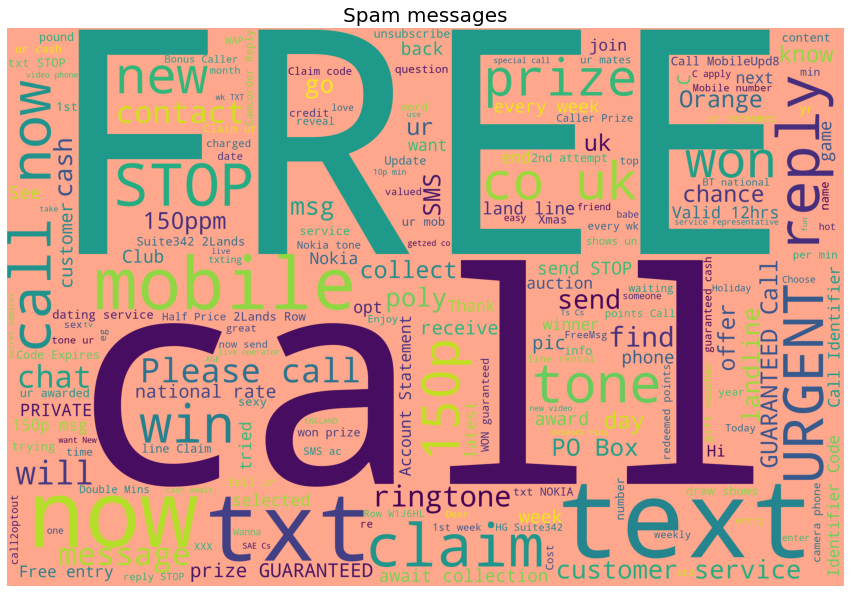

In [13]:
show_wordcloud(data_spam, "Spam messages")

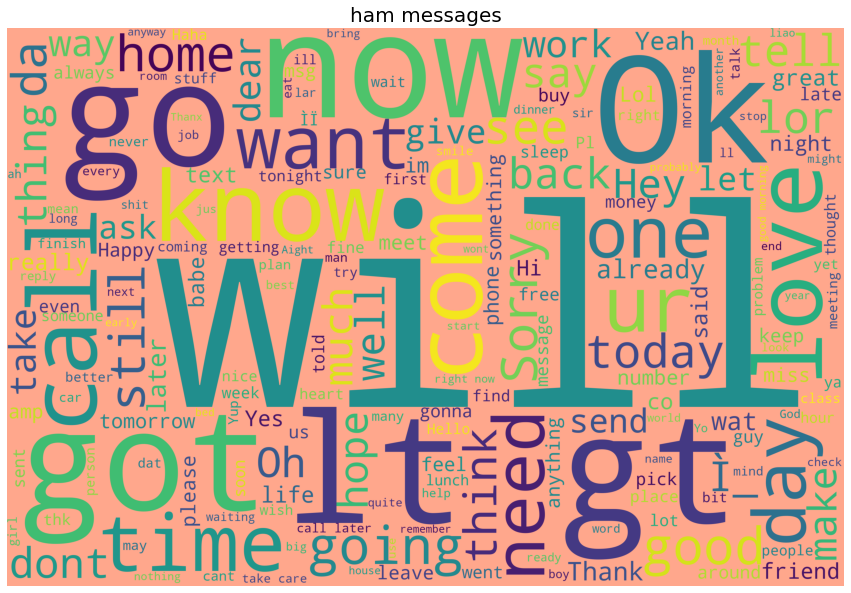

In [14]:
show_wordcloud(data_ham, "ham messages")

### Preprocess the Data

The process of converting data to something a computer can understand is referred to as pre-processing. First, we’ll convert the label to numeric form. This is essential before model training, as deep learning models need data in numeric form.


In [15]:
df['class_label'] = df['class_label'].map( {'spam': 1, 'ham': 0})

Process the message content with Regex to keep email and web addresses, phone numbers, and numbers uniform, encode symbols, remove punctuation and white spaces, and finally convert all text to lowercase

In [16]:
# Replace email address with 'emailaddress'
df['message'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
df['message'] = df['message'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
df['message'] = df['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
df['message'] = df['message'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
df['message'] = df['message'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
df['message'] = df['message'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
df['message'] = df['message'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
df['message'] = df['message'].str.lower()

we'll remove stopwords from the message content. Stop words are words that search engines have been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query

In [18]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['message'] = df['message'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

[nltk_data] Downloading package stopwords to /home/ryan-
[nltk_data]     len/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We will extract the base form of words by removing affixes from them. This called stemming, here Snowball Stemmer was utilized due to its computational speed

In [19]:
ss = nltk.SnowballStemmer("english")
df['message'] = df['message'].apply(lambda x: ' '.join(ss.stem(term) for term in x.split()))

Machine learning algorithms cannot work with raw text directly. The text must be converted into numbers—more specifically, vectors of numbers. Let's split the messages (text data in sentences) into words. This is a requirement in natural language processing tasks where each word needs to be captured and subjected to further analysis. First, we create a Bag of Words (BOW) model to extract features from text

[nltk_data] Downloading package punkt to /home/ryan-len/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of words: 6526


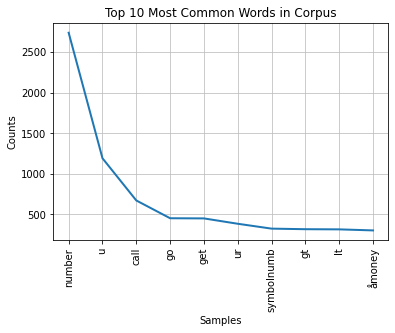

In [24]:
sms_df = df['message']
nltk.download('punkt')

# creating a bag-of-words model
all_words = []
for sms in sms_df:
    words = word_tokenize(sms)
    for w in words:
        all_words.append(w)
     
all_words = nltk.FreqDist(all_words)    

print('Number of words: {}'.format(len(all_words)))

# plot 10 common words
all_words.plot(10, title='Top 10 Most Common Words in Corpus');

we will implement an NLP technique—term frequency-inverse document frequency—to evaluate how important words are in the text data.tfidf_model created from this NLP technique will be saved (serialized) to the local disk for transforming the test data for our web application later:

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
tfidf_vec=tfidf_model.fit_transform(sms_df)
import pickle
#serializing our model to a file called model.pkl
pickle.dump(tfidf_model, open("../model/tfidf_model.pkl","wb"))
tfidf_data=pd.DataFrame(tfidf_vec.toarray())
tfidf_data.shape
tfidf_data.head()

,0,1,2,3,4,5,6,7,8,9,...,6496,6497,6498,6499,6500,6501,6502,6503,6504,6505
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The training set should be later split into a train and validation set.

In [29]:
### Separating Columns
df_train = tfidf_data.iloc[:4457]
df_test = tfidf_data.iloc[4457:]

target = df['class_label']
df_train['class_label'] = target

Y = df_train['class_label']
X = df_train.drop('class_label',axis=1)

# splitting training data into train and validation using sklearn
from sklearn import model_selection
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,Y,test_size=.2, random_state=42)

### Model Building
We will be utilizing a machine learning algorithm known as LightGBM. It is a gradient boosting framework that uses tree based learning algorithms. It has the following benefits:

Faster training speed and higher efficiency
Lower memory usage
Better accuracy
Support of parallel and GPU learning
Capable of handling large-scale data
The performance metric for this project is the F1 score. This metric considers both precision and recall to compute the score. The F1 score reaches its best value at 1 and worst value at 0.



In [30]:
import lightgbm as lgb
from sklearn.metrics import f1_score

def train_and_test(model, model_name):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(f'F1 score is: {f1_score(pred, y_test)}')
    
for depth in [1,2,3,4,5,6,7,8,9,10]:
    lgbmodel = lgb.LGBMClassifier(max_depth=depth, n_estimators=200, num_leaves=40)
    print(f"Max Depth {depth}")
    print(" ")
    print(" ")
    train_and_test(lgbmodel, "Light GBM")

Max Depth 1
 
 
F1 score is: 0.8870292887029289
Max Depth 2
 
 
F1 score is: 0.9236947791164659
Max Depth 3
 
 
F1 score is: 0.9149797570850203
Max Depth 4
 
 
F1 score is: 0.912
Max Depth 5
 
 
F1 score is: 0.9133858267716536
Max Depth 6
 
 
F1 score is: 0.9098039215686274
Max Depth 7
 
 
F1 score is: 0.9133858267716536
Max Depth 8
 
 
F1 score is: 0.9169960474308301
Max Depth 9
 
 
F1 score is: 0.9206349206349207
Max Depth 10
 
 
F1 score is: 0.9206349206349207


In [32]:
from sklearn.model_selection import RandomizedSearchCV
lgbmodel_bst = lgb.LGBMClassifier(max_depth=6, n_estimators=200, num_leaves=40)
param_grid = {
    'num_leaves': list(range(8, 92, 4)),
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'bagging_freq': [3, 4, 5, 6, 7],
    'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10),
    "min_split_gain": [0.0, 0.1, 0.01],
    "min_child_weight": [0.001, 0.01, 0.1, 0.001],
    "min_child_samples": [20, 30, 25],
    "subsample": [1.0, 0.5, 0.8],
}
model = RandomizedSearchCV(lgbmodel_bst, param_grid, random_state=1)
search = model.fit(X_train, y_train)
search.best_params_

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5 will be

{'subsample': 0.5,
 'reg_lambda': 0.47777777777777775,
 'reg_alpha': 0.5722222222222222,
 'num_leaves': 88,
 'min_split_gain': 0.01,
 'min_data_in_leaf': 10,
 'min_child_weight': 0.01,
 'min_child_samples': 30,
 'max_depth': 3,
 'learning_rate': 0.1,
 'bagging_freq': 3,
 'bagging_fraction': 0.6}

In [33]:
# Use the best params to train the model

best_model = lgb.LGBMClassifier(subsample=0.5,
                            reg_lambda= 0.47777777777777775,
                            reg_alpha= 0.5722222222222222,
                            num_leaves= 88,
                            min_split_gain= 0.01,
                            min_data_in_leaf= 10,
                            min_child_weight= 0.01,
                            min_child_samples= 30,
                            max_depth= 3,
                            learning_rate= 0.1,
                            bagging_freq= 3,
                            bagging_fraction= 0.6,
                            random_state=1)
best_model.fit(X_train,y_train)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=3, max_depth=3,
               min_child_samples=30, min_child_weight=0.01, min_data_in_leaf=10,
               min_split_gain=0.01, num_leaves=88, random_state=1,
               reg_alpha=0.5722222222222222, reg_lambda=0.47777777777777775,
               subsample=0.5)

In [35]:
#Performance of the model

prediction = best_model.predict(X_test)
print(f'F1 score is: {f1_score(prediction, y_test)}')

best_model.fit(tfidf_data, target)
pickle.dump(best_model, open("../model/spam_model.pkl","wb"))

F1 score is: 0.891566265060241
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.5 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=10
